In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ()).rowVector()
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ()).rowVector()
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

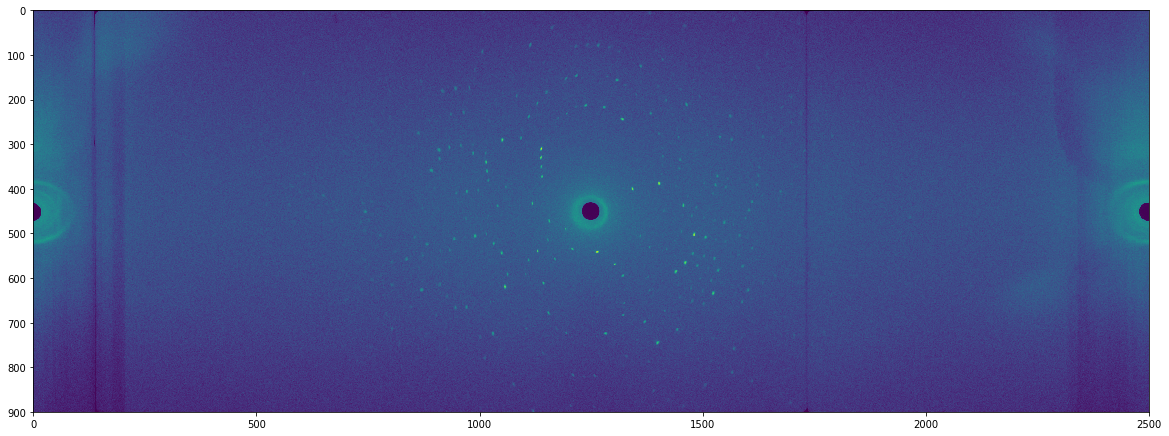

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.frame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
peaks = finder.find([data])
print(peaks.size())

9203


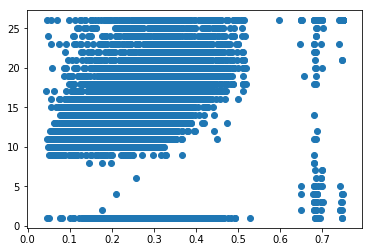

In [8]:
qs = []
slices = []

for p in peaks:
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.show()

In [9]:
data.integratePeaks(peaks, 3.5, 6.0, nsx.ProgressHandler())

In [10]:
for peak in peaks:
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)

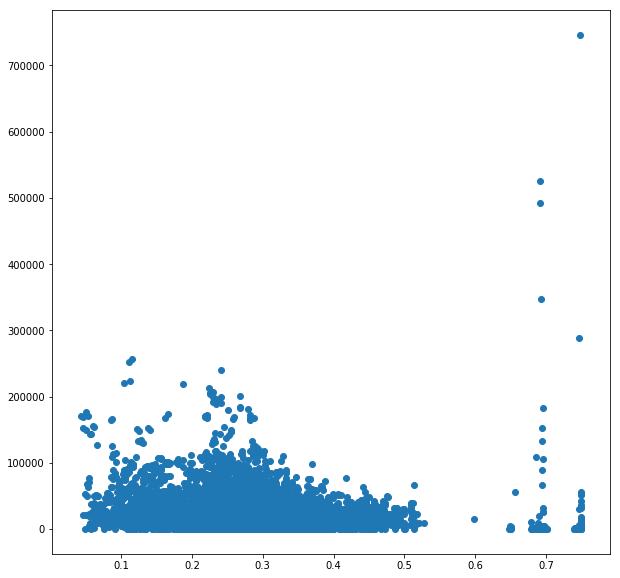

In [11]:
plot_I_vs_q(peaks)

7869


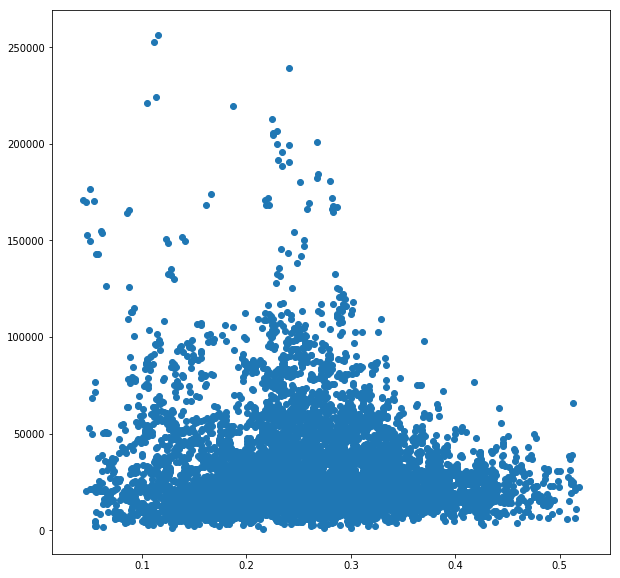

In [12]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [13]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = np.array([[0.,0.,0.]])
    if uc.getMillerIndices(peak.getQ(), hkl):
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 7869 peaks
indexed 7683 of 7869
found unit cell with parameters: 
a:  54.90215864191287
b:  58.612764713728765
c:  67.2288279863522
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948966


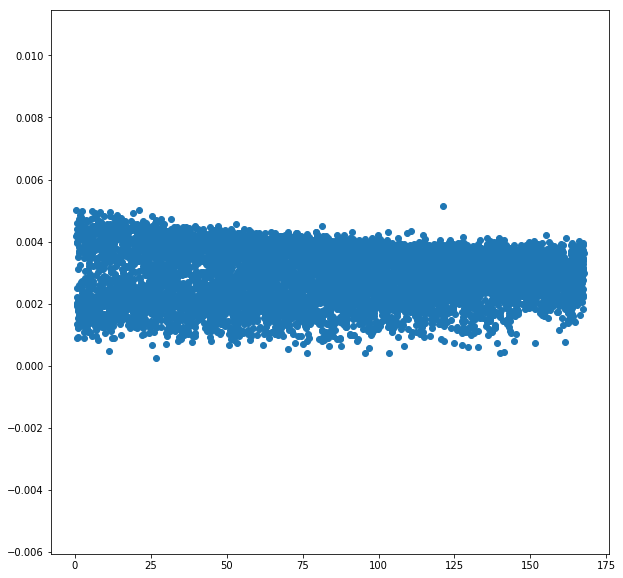

npred 7615


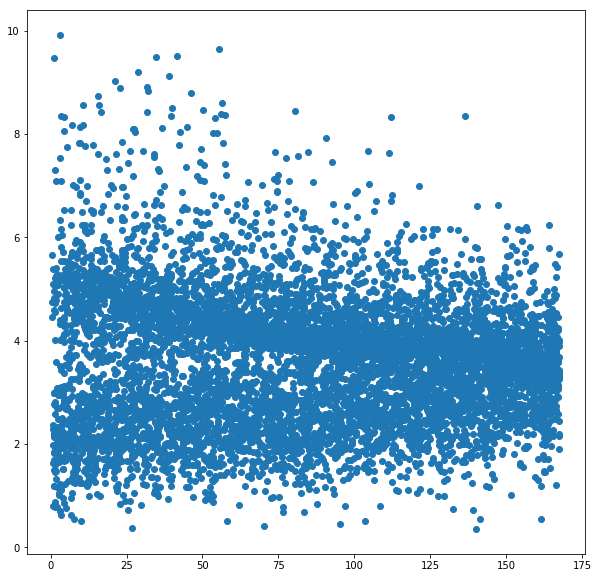

In [14]:
plot_dq_vs_frame(indexed_peaks)
plot_dx_vs_frame(indexed_peaks, 10)

In [15]:
nbatches = int(data.nFrames() / 15)
#nbatches = 1
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


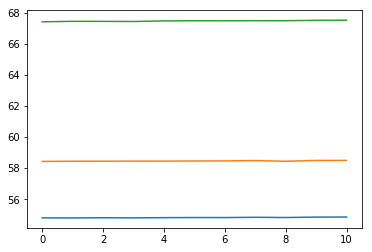

In [16]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

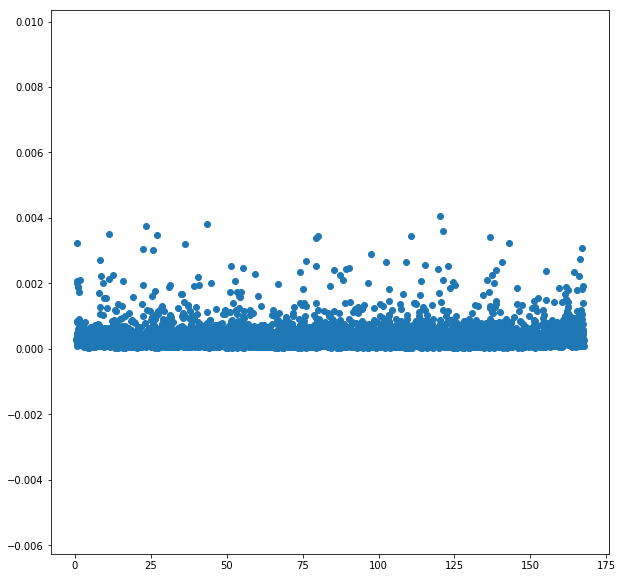

npred 7621


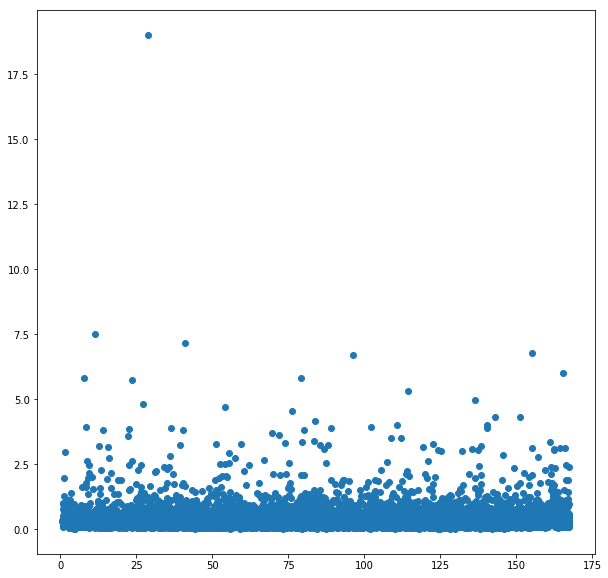

In [17]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)
plot_dx_vs_frame(refined_peaks)

sample position


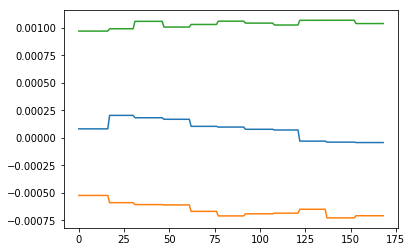

sample orientation perturbation


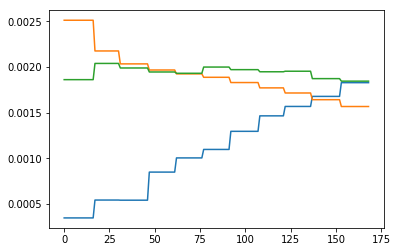

nx, nz


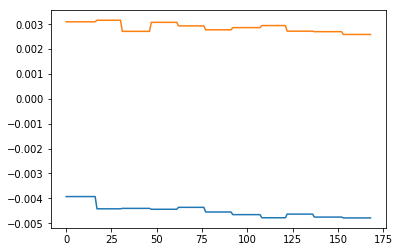

In [18]:
print("sample position")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, nz")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [19]:
len(refined_peaks)
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9912137112633784,
 'CCtrue': 0.9977912961905815,
 'Rmeas': 0.04836076031294883,
 'Rmerge': 0.03866907850535745,
 'Rpim': 0.02846271230006297}

In [20]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [21]:
peak_set = nsx.PeakSet()

for peak in refined_peaks:
    peak_set.insert(peak)

In [22]:
data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9901917066175191,
 'CCtrue': 0.9975327985208139,
 'Rmeas': 0.04836076031294883,
 'Rmerge': 0.03866907850535745,
 'Rpim': 0.02846271230006297}

In [23]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.diffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred
    
predicted = predict_peaks(refined_peaks, data, 1.5, 50.0, uc.reciprocalBasis(), refiner.batches())

In [24]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak_set.insert(peak)

data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9543869825347908,
 'CCtrue': 0.9882617138516326,
 'Rmeas': 0.21886021201947858,
 'Rmerge': 0.17644981745594848,
 'Rpim': 0.1265426545014579}

In [25]:
high_q = nsx.PeakSet()

for p in predicted:
    q = np.linalg.norm(p.getQ().rowVector())
    d = 1 / q
    if d < 1.5 or d > 1.8:
        continue
        
    high_q.append(p)
    
print(len(high_q))
data.integratePeaks(high_q, 3.0, 5.0, nsx.ProgressHandler())
compute_statistics(high_q, nsx.SpaceGroup("P 21 21 21"), True)

17759


{'CChalf': 0.5849884012060804,
 'CCtrue': 0.8591630305443354,
 'Rmeas': 0.7124078093368821,
 'Rmerge': 0.5556301700649648,
 'Rpim': 0.43675162853911875}

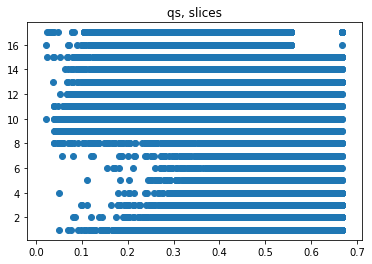

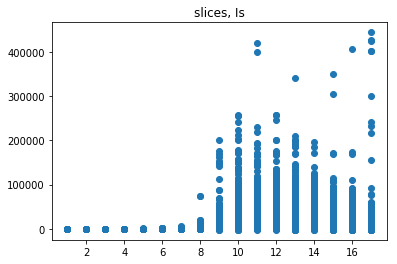

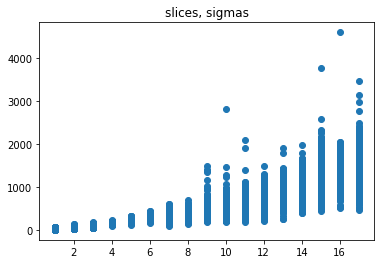

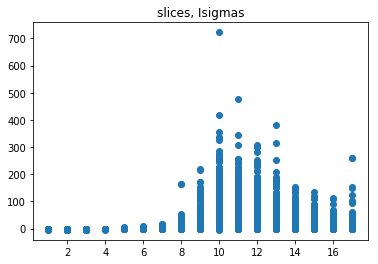

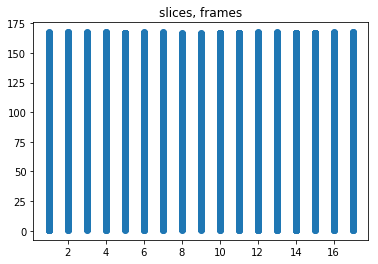

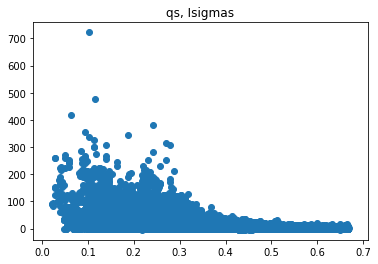

In [26]:
qs = []
slices = []
Is = []
sigmas = []
Isigmas = []
frames = []

for p in predicted:
    inten = p.getCorrectedIntensity()
    isigma = inten.value() / (inten.sigma()+1e-6)
    
    #if (isigma > 1.0):
    #    continue

    frames.append(p.getShape().center()[2,0])
    Is.append(inten.value())
    sigmas.append(inten.sigma())
    Isigmas.append(inten.value() / (inten.sigma()+1e-6))
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    slices.append(p.getIntegrationRegion().bestSlice())
    
plt.scatter(qs, slices)
plt.title("qs, slices")
plt.show()

plt.scatter(slices, Is)
plt.title("slices, Is")
plt.show()

plt.scatter(slices, sigmas)
plt.title("slices, sigmas")
plt.show()

plt.scatter(slices, Isigmas)
plt.title("slices, Isigmas")
plt.show()

plt.scatter(slices, frames)
plt.title("slices, frames")
plt.show()

plt.scatter(qs, Isigmas)
plt.title("qs, Isigmas")
plt.show()

In [27]:
Isigmas

[21.577041232350012,
 28.840119586887468,
 20.765808001244686,
 7.551305469139877,
 57.75804823597773,
 48.18338034755118,
 16.38993218025827,
 13.055370425393543,
 75.02544000401161,
 -0.2992950429797037,
 3.336055271181776,
 21.397003820820654,
 10.401301953161356,
 -0.978155911812544,
 -0.44531434984710566,
 -0.6382242355890613,
 12.750483675707319,
 10.533947312200022,
 17.37339505688392,
 25.078165760614255,
 16.85417813010294,
 -0.31785094217594345,
 -0.01782063806063913,
 7.787923087826124,
 11.94612886437407,
 14.135158463479286,
 8.53289929481757,
 3.3344561051871398,
 -0.3573702401437622,
 17.221120567106624,
 7.222736054719284,
 12.228879044022637,
 6.868359786248212,
 13.143428092005497,
 5.936976005924576,
 7.267836628990218,
 19.00571674973858,
 34.0413461868514,
 8.650892888363389,
 47.02463812318131,
 36.74759704584792,
 13.823789405163234,
 6.153350643066293,
 -0.3018332427369633,
 -0.8243070593271872,
 4.884840447995031,
 24.438516167538555,
 4.177728429485504,
 15.32

In [28]:
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

for p in predicted:
    print(p.getCorrectedIntensity().value())

12856.588081956534
21530.292640416734
16587.15068955161
7882.570706029033
34947.265897936944
20186.695996286177
5033.827438594834
6338.246915813727
49391.15525828451
-282.3170180675468
3121.1674469075815
10253.34975916754
9254.569952693188
-14.25084130879043
-474.80173188362846
-248.40947048023443
5897.435992402355
6570.196097914262
9034.43050894988
14588.292904727488
9599.51630728374
-29.928206039952997
-18.24914903204644
5543.230045263047
17160.30518673037
14390.490701461815
7684.1607743316445
4649.45368621281
-494.76299782057043
18861.962147378294
7763.36646953474
12995.177658844315
5705.467455349705
16883.589007641964
7426.588139096679
5890.2592086916175
19968.236048558698
37288.07948636591
9389.626856914558
43503.08081748817
35078.85753759327
12933.906115538122
4916.004335620915
-55.87650607779279
-594.4615284106037
2693.7977402024576
7743.2915842635875
3348.2586886666445
5604.538649422983
9414.424919103547
-369.59208827677696
4523.017312317242
3117.8113365650993
29148.36778503943

-309.63806066847735
-5.386509481309152
-13.431122796730133
0.0
-42.61755312040117
-88.33910895666737
-20.489284457196206
-4.497115737306063
1369.864014279171
-34.740546350152606
7037.166086960068
-23.895231674913752
1444.9442139857497
0.0
1163.0342609371087
-31.471741166776248
1156.0865792889438
1788.2047513906712
9328.191215407029
-33.91028342094948
-21.938174094367398
-47.124555925471356
0.0
-30.667731115170234
3438.463831097544
-55.82926267548941
7324.549073763615
-9.606069491090256
2849.0160322438614
8573.394844118091
-34.382076402347955
17234.558519818518
-45.36121381528107
-114.31914647457889
4530.774488970832
6016.586211387749
9547.050862909691
9377.485200749847
17884.019523458475
9700.327956719944
0.0
3062.585429697486
-14.410309128038758
-15.077185587908184
13045.203935869482
4302.6975897124175
0.0
0.0
31273.672745808268
0.0
-35.01766021794417
10067.200707904212
8991.039687584967
-2.4584664535639305
4756.009792262037
16327.481805784442
30130.0366494999
7784.447619195448
0.0
38

-49.707696495928495
7757.6398204895395
1969.3092506360476
9411.854772667826
18638.727714723067
-3.3202017120530734
2679.952719282946
50119.09975365311
-57.16721129225896
8185.849313032721
-20.466787387373966
-17.615315923818507
0.0
-5.4497751134068375
-8.632461550274845
-21.968071051603136
1935.2828778060857
15077.029703953025
15612.319232913125
-1.4195221771840623
3616.5781347659904
-110.93268336437396
2143.0587315312914
1948.7314707878354
3827.792870170849
-95.08007949324394
7675.6477087598905
-14.693604520232904
5503.4544458209375
1516.781529523971
3198.983097735547
-17.6094710459261
3455.5549232686094
-195.639101856871
11715.818869650624
6378.0450182393915
-3.5607861274478436
-50.8182583007405
3709.394517679083
-100.2856390709297
12260.079389279577
3368.8719316409733
1725.734258039794
-26.433691781934712
-12.025954585252418
-20.050073565290447
11892.627474141242
0.0
7494.182394787126
-270.2307605947381
-187.05429795935345
0.0
-1.6325018189379015
-28.890265778490882
-12.832949455631

3816.141853964685
26926.61427945109
39351.35921826378
12043.896061568683
9695.336925414398
2715.3287404706566
1846.0837377867974
-414.7818983364014
-11.002054610307905
2519.491479975387
2674.536613689392
15386.852716583913
3789.8766108137697
2873.994590114425
10567.374418512052
14340.502157322155
24059.874317400885
1592.377921555291
5535.836005397816
-6.511502200239873
9108.49030108503
5390.829605417419
-24.43328877089794
2805.8716174007627
-4.8272749522331555
5087.422492675517
-8.465892592264582
23505.43551118168
13591.523626015294
6811.054178134297
10919.288816247335
-215.89117342961873
23224.80635064241
11877.24689980534
-23.781901082544525
8054.936157337519
8035.690352857991
33659.44720526333
11469.113192171299
2196.5543815492438
21418.812397146106
3450.915231403549
-31.11419997805243
54609.33647747741
8135.446390704416
974.5081867922102
15637.875916945699
31574.122589962066
4642.735457642599
23017.239648799794
14778.45410960362
25959.126265022584
-11.208898051710788
3103.081649717

10167.072609331688
9954.34183426817
-77.99193308580342
-5.355310866869637
-15.283741709993846
1836.3823433243115
0.0
-42.88610746653103
-3.892826664835556
-67.35439370088012
0.0
-21.49609435364518
-30.496347133146536
6310.218485953072
-6.649450229499688
-88.01260769628007
-15.260917470210025
1932.0039244574743
-53.77205625079505
3416.9234142553682
-51.27615483298138
-18.95456333657639
-190.5606127732163
-5.793108786980594
-0.015929589199959297
-20.228533822243794
1011.8641915015099
2242.6586316318876
3894.760022861267
-12.266526461274111
-20.536986409298
2031.9942852352838
0.0
-70.2884688858608
5953.357836776124
14587.035549364065
5225.1563447209555
2618.1502362175665
0.0
0.0
18655.253651828632
-12.17958277880169
3232.5320943797883
-44.90831977139316
0.0
-27.83185647591315
-20.512300330817332
2602.525904861884
-117.69532969710458
0.0
7530.1717627370435
4592.121432143128
4901.974578639656
4990.575706374752
20543.50704580568
-11.868369955336078
-13.196021387710605
-31.000388351414166
335

-8.44040295646903
-9.437429793494001
12866.795110782416
-90.10970015295813
13266.59855450277
13649.851668206014
19691.68146477753
0.0
0.0
10974.40374451386
7162.17403177905
14466.408326128763
3816.180377520886
0.0
8337.012773600605
9438.5183811517
-148.0811919053141
-410.16038379660114
8141.036717334037
20706.5913580089
3377.1659279064115
10782.068939827457
2939.7038554548626
25197.469582177047
9152.746430442377
6015.698211853517
49836.05522525241
23652.435456199888
28966.79979764004
37365.72704428409
7463.481609260758
18274.38034077106
-237.82123800979676
60344.30808581348
8689.748180877737
31741.589289305215
17105.499956398755
18656.353784039693
27634.53840384819
25017.180476919046
7377.736092042608
77620.98948887775
0.0
0.0
39647.47912677077
15842.134204882475
14854.207674281506
4593.427611679377
3564.7317552100567
113549.87979032997
-67.14454459071162
-17.823333911201257
79267.64149886403
6664.683229824553
-557.3227710055714
-27.34777960162197
4440.454616021632
42612.6461203822
177

6985.720377409013
-29.602505909284798
-52.90847547817805
4433.283910229356
0.0
-29.147720603844302
6264.341927130688
-39.590831278456285
5271.756650476928
-27.851431486018026
7286.795466294873
-39.35785501766114
5601.3582411460275
8889.877165289368
4602.595468967947
15684.750101674337
3230.787959115807
0.0
12148.808768089237
0.0
15036.675856425716
21282.9885572839
-737.2040556287266
15153.21846190718
-25.147821991782248
7381.808538799748
-0.5876131418064645
-25.718420950782672
-85.72535021009877
8095.6629118105275
2154.473661397673
1150.0214071025882
3015.9602018564856
7961.001017242707
-29.585168059965998
5822.116157136419
5511.7292691128305
-8.916917391579172
11232.651035101728
-25.945529104708058
-28.79598115389385
6338.557769280251
82651.87255013674
11022.615873421119
0.0
-16.297621953420688
26832.464436619706
11366.774036112702
1879.524698281551
14520.14322457877
16957.47664695346
101830.67979555493
28026.32013306284
16520.541236666842
75144.13347774252
27632.30062617347
24917.514

-42.4151020382064
3449.0446892688938
-4.628028314052306
-10.965138418596863
8361.844709572992
-23.242471036634555
4202.419737794216
2497.7642406275777
11866.015171736533
-23.524222681496703
5670.313238038916
-14.028607563357196
-371.36859251665646
2724.1202850752347
-23.416841378081717
-2.0076980065442016
7077.523067389407
-29.195444119712143
-67.58907981265826
7157.016353288141
9320.112496092013
47224.12432155576
8928.677235688885
5919.866187571353
-54.3353897793952
-975.3807815920321
-77.91182054505663
-49.493024424917195
42132.37464862361
1586.1339911809703
-14.598869533153206
0.0
9257.237506026811
11860.424122542294
7633.818400101728
12774.516977185445
21496.44991625025
8878.737330395918
-19.284855862552686
8393.534453454695
-44.77910100350787
7142.202068607105
0.0
5149.466019531859
11321.087014198069
6567.367150081688
0.0
37787.89484977408
21734.454580467627
43198.208316260236
12648.189089764834
15367.571581790562
7320.6812006145165
3829.727259918542
10236.593180164238
10744.26234

-23.65945971960646
-15.42168115241323
4756.949085959972
0.0
-37.02973900455976
-35.988953667149666
-62.25901533344159
20062.286743007233
-43.52426693981838
-50.98252706967547
0.0
13487.736372689124
-98.01730932432538
-20.324385207474943
-1.2606628736026326
3341.257130257491
9290.115890482964
2588.5220245936857
2848.014321022752
5811.868584082673
3991.498234817588
10088.434889720074
6690.795770677274
-8.595793508749386
4783.132421476889
7775.230202952736
4932.986814592165
2765.578962334322
-113.07782378582841
7018.297733279767
7268.952938852248
-16.375009627777867
2189.9057132004605
-21.67446421979457
6215.6276477296915
3390.038457014646
3069.3910579677913
6204.226000806373
1998.8526332865847
7404.158284519491
0.0
-8.28815952438976
4041.827883281067
-27.812543911112698
18554.500738877796
-0.9974741881841293
-64.02680222808496
1808.691008377871
-48.01888188167338
8033.701393159954
9030.077411853517
-22.99763254322334
9803.689800798751
3120.3971758206485
3639.985017830054
5349.92753387589

3829.187675337804
2798.3893108934094
0.0
-8.52310711905079
14100.041246772567
-76.62189615847674
4193.061736915181
-12.559493589265331
4691.450517907894
4232.984505102983
-0.16798501537108404
-38.76106575660905
12943.199955781583
14477.586214059509
2064.7408143696707
-54.72585678759653
-7.322444054994421
-103.03949460257321
10160.194091212428
6104.860488717521
3642.432944102515
4866.763270424062
-5.610481967807799
-32.129471754708504
-136.67699070081832
24489.611530336115
-84.40711733945245
0.0
-52.77297049785413
8147.110527808827
-283.53241168966144
5338.3390031041545
6829.531526660633
3686.2095968328695
10657.349374893454
-7.064611839484313
10300.292095256063
-299.2673114929689
2169.628021977509
7838.284340076325
-90.23963111147671
7495.993051327426
0.0
-57.91240415872849
39173.17919495707
-32.88155888374508
12131.55022965245
2369.177971289265
46833.99177714275
11591.20487439453
2765.7252045653768
29215.379611506494
55652.42066741109
40840.77542202934
23220.032584098815
16821.1024549

12448.748677805494
9921.36488223879
19606.548916148266
-4.782425561210356
-39.62154414681608
-148.4700624256814
13270.308482168608
2425.7289243848572
-41.87225921939012
4006.2577318616645
-114.74409392723992
4597.594315913154
-10.31045738412195
14440.623834439968
10491.304396993914
19045.00866737858
-199.65245823392831
-99.66733941635732
-79.6404547709543
5976.458341783524
-68.87095791317313
9334.948337679407
3042.057050362112
7046.943567305911
8253.970940932733
-7.381814329931205
14417.554654947078
3156.854877125232
6392.27391055842
34688.83852277962
9492.602635818459
-9.435564788118096
15113.156191845752
-1.6890202505492022
13038.385547208467
5753.342588494292
13349.072940476044
4857.460395613917
-49.768813259900206
42354.747686605515
5882.327120099324
6078.080219281912
1935.963008501269
-45.98195705494606
11944.20725267425
14134.621190905531
43221.52822730314
22026.656627887063
13380.203667710262
122454.12511607232
16303.46606630895
0.0
0.0
7546.14059769596
11434.130211513992
14260.

10550.875391190812
1366.143518907569
2489.1919057198716
-15.020153483807261
15427.737989119443
-52.68073088219798
1257.9310680931287
8662.518083094366
-152.17235835017433
1843.7615075018393
878.2110359742653
13778.850639986384
4361.052059385369
-36.22704931358831
-67.7078430603478
0.0
-37.02506576626662
-141.17013652799338
0.0
8309.709576553889
3901.7419850449833
0.0
0.0
-15.271139116775057
-16.71182917627631
6344.19092191848
3423.214277305288
-157.7799853852982
1842.5445497808075
-126.68475710564165
1793.5633425415886
-1.5382676540349036
19388.735653848496
18180.41981150136
3335.82139699668
-57.84044185237549
18836.68684452072
10493.03770563865
15000.723321389858
2400.370532121452
14316.154181267364
-728.6002041576716
-16.913116450127514
2311.967520405315
7109.369786407037
56979.51127227539
4713.936439564292
4297.528992452067
-2.294684735888575
-86.42094073063747
-19.747663118427052
6322.253599392857
-178.00160175282153
6825.4722459080995
3717.1194233007013
-11.841558875667797
1817.12

-12.989864609711388
17093.04534536439
-25.53491862894024
0.0
14352.690973570505
8479.56273749357
16059.77486307463
-32.63845308571036
-90.41787095992781
9445.769004900743
0.0
2950.2685059127575
0.0
-13.627204184760622
4662.211887427635
7046.727725236489
20073.873914441756
3019.815247254442
23759.92542948276
2069.9341410663915
27955.50992689292
15253.43679496543
57652.20535171935
38042.59480540548
8626.344727867609
-60.66042179166247
5739.258798465286
2694.392582271562
41054.52832361338
2736.237391447238
1038.8807040906063
-380.4456345943093
11211.037101177033
-38.717514293621406
3247.256268304463
-7.446434051597092
1798.3345664209726
-26.93572105368092
17279.991568401234
32413.27932374198
-43.23784524676754
2383.438958837647
0.0
12282.433110174565
4278.743614870508
-1.406507180203124
-5.263893115132038
13557.405574262573
29960.597756561394
-41.29396623934184
-34.77045006951752
7511.110750599996
-24.593316913045705
-73.15106421808011
-32.74035382544595
8317.194342430124
34753.9563971561

2068.4720165647864
2726.2861909079484
4879.144199411482
-19.940996804407735
4196.788352715669
-39.27796960297831
-64.67635784104176
7502.923469187453
-86.70635240621174
4227.89892059253
-3.1683415866093916
16711.245474640873
4471.53082756539
-26.26622379575356
-22.58502244998774
4540.3627396992915
3388.5519065122985
6881.697711048304
-82.95748396032137
10747.05488348988
1112.8694583222905
11595.44058243001
-68.24037870952104
12452.066646904294
19375.37064978584
11937.852930396586
4877.313001344337
4362.066032918114
1670.3745192897734
7067.912869545122
-29.81911143469933
8825.512012209025
8211.627154180547
19417.65417257832
-6.655700981798728
-238.53398633571496
13571.040098229381
2046.6154045436626
3037.379443563064
-3.7822276739166556
9091.011768014665
-153.6195088593798
-83.94969742935085
-12.824695052835684
11060.13629476074
-124.90052201887471
8067.494179182123
-14.01584227329946
1735.696688380455
1998.6202516980072
0.0
5397.97532525948
1414.4309845798587
-149.94815971649996
-20.50

-37.052752711722796
-14.279158401223347
0.0
4706.7353541466855
7713.945159565921
-56.75845636243279
9211.336191226419
8743.872976863691
-5.758572689948531
-8.788162611862216
10798.811699583666
-266.66803513060444
7225.284480160252
5721.1620989047515
2646.323620903823
8137.167655811503
7199.629008275948
14456.513162614006
-52.801021788589
-1.5526536823212498
23557.943173655513
-42.46063674313327
-60.88442461251375
-121.30445745314024
16701.29259504259
9964.80786629813
5981.679913217309
10878.677710875094
0.0
-12.241234082035426
4331.174026115087
2325.5534171327517
2796.6920412590275
7115.632766509443
-55.42264441131635
7302.206623796517
77519.71766736785
629.5316766947582
13959.051451604757
9427.222755843763
-6.712477467758669
4358.408646229559
-77.53965906645426
-85.24575206079872
2771.5099927476317
13819.011827102799
0.0
3689.817814330986
-18.743170414778376
-54.62195358251936
4369.034464260321
-0.9348355532970034
-41.687246350941045
5501.012125258071
-166.90481999640528
4191.42199008

-93.03116098440319
5386.5035291746035
6613.819353574683
-6.1542884110712635
5693.337705206421
6449.178963926272
23807.58762390044
8336.72956075858
-3.2268128790452018
12242.611213464574
2797.368609075639
-60.97790771302588
7448.048468985314
10582.112042454077
-13.91575637560752
-52.62932452929441
17260.39649454589
5986.360711700418
9436.842415793983
81216.093216352
15225.474608426133
4356.464682349014
24340.2967167671
34319.767085014006
36123.90018729039
24459.7854708026
27489.32980532039
5295.124133255371
35604.444765626395
4925.646891046383
14531.958061498866
41177.73835788895
12941.217313724665
0.0
2019.3996140334025
24242.463367146345
34973.70939358892
12374.82774047911
55126.97283634235
75487.32569854731
3293.612866302701
21002.355338090292
1723.809847015799
-211.05227012175277
2347.110926320752
-29.40202180933678
1097.558463356993
4573.301651630868
6134.491422217271
-4.047162635245573
13426.261429990951
8752.674442461901
13072.83121581655
-56.395830277326084
0.0
-63.0469970222683

18836.682731495992
14599.40722200038
5859.77990624973
10882.146652554073
1656.1420104117135
0.0
34301.73064364684
-22.719360338817676
7006.833911673094
2528.2331710622616
24536.971871580732
15110.211599336253
62139.01076093156
4658.50414171817
50216.001060444156
14321.014257121447
-34.44472881623832
25260.414208029255
31079.411326223853
5356.143308718953
18120.730544530546
46479.13604719701
39944.40575559119
41589.62394014873
16595.151172453243
40283.31191388285
11437.977546859063
13831.750026265318
8282.156485358886
-8.342755898902391
-26.43573150906864
-56.828935721139445
1390.435544073646
-27.401464731251316
4452.35657821903
3423.648274607966
-10.719824798563426
2497.178311790973
-28.72833141819422
-35.188214422994676
-22.987779500208145
-42.80366856731642
-21.505876401091687
-78.2260506021356
-14.109143686547053
-21.61936139588705
-24.712824092873685
-28.156635127387972
3560.9231655611893
-20.193448636104897
2514.5233813392574
-15.700862992696448
-44.81961616555734
-28.673428257486

6680.344099811207
-1767.53051836386
8878.631423360615
15471.541426801276
8448.133339779275
12206.635295277241
5997.796662980704
2006.2168066586823
10102.04371084541
4984.432884560751
-30.178791022193906
-2.8307585706813305
5819.714772849904
-47.12665365268441
12607.086690049484
1420.8519647735575
2368.2512383965413
5055.162388389183
-121.05936675304157
51873.607059040405
7038.754284276244
28750.911592634697
-73.16515356893656
14245.057935571474
6986.494955643941
4194.590076751716
67403.61743511101
-5.249983316664341
4847.080156708595
3618.7306298488534
7854.037669506127
17913.438886628563
10075.30713902362
12773.211665514882
2841.1320572982063
5468.428160001713
12501.910404800925
10045.5405789257
16470.055368405425
0.0
23745.252650545724
16825.443541633267
10740.113825860473
11030.374489418775
8368.594458216194
-929.2704257561621
-58.64614733247221
-14.328868810348375
1857.925760509336
-17.455493934168466
-33.08255377989126
-44.30724037424142
3720.053195069266
-21.60743473458575
-42.95

In [29]:
strong_peaks = nsx.PeakSet()

for p in predicted:
    inten = p.getCorrectedIntensity()
    I = inten.value()
    sigma = inten.sigma()
    
    if sigma < 0.1:
        continue
        
    #if I / sigma < 0.5:
    #    continue
        
    strong_peaks.append(p)
    
print(len(strong_peaks))
compute_statistics(strong_peaks, nsx.SpaceGroup("P 21 21 21"), True)

55121


{'CChalf': 0.9841118924752855,
 'CCtrue': 0.9959881188546813,
 'Rmeas': 0.15387735354988172,
 'Rmerge': 0.12305764202373873,
 'Rpim': 0.09044726897883984}

In [30]:
p = high_q[100]
region = p.getIntegrationRegion()
intgr = p.getIntegration()

shell_inten = intgr.shellIntensity()
shell_point = intgr.shellPoints()

In [31]:
bad = None

for p in high_q:
    inten = p.getCorrectedIntensity()
    
    sigma = inten.sigma()
    I = inten.value()
    
    if sigma > 0.0 and I/sigma < -5.:
        bad = p
        break

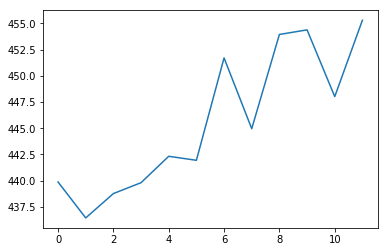

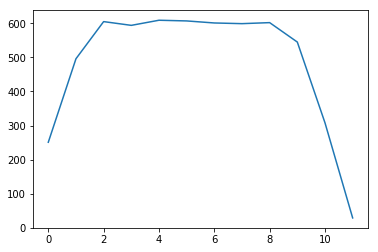

3


In [32]:
shell = p.getIntegration()

plt.plot(shell.shellIntensity() / shell.shellPoints())
plt.show()

plt.plot(shell.shellPoints())
plt.show()

print(p.getIntegrationRegion().bestSlice())

[[556.63693099  39.93078963 151.9278549 ]]
[[565.4177954   54.13941251 154.31661521]]


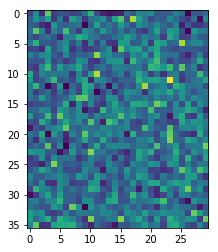

444.75555555555553


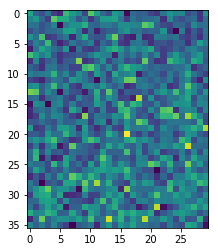

446.6259259259259


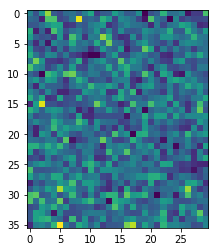

443.7962962962963


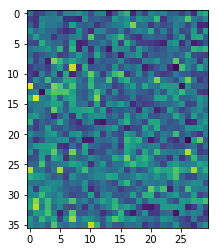

447.0342592592593


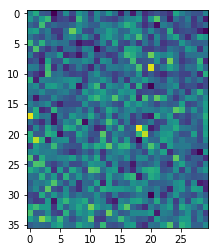

444.7962962962963


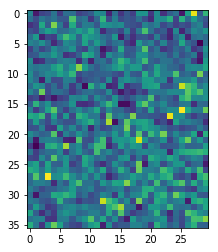

448.76296296296294


In [33]:
bb = p.getShape().aabb()
upper = bb.upper()
lower = bb.lower()

xmin = int(lower[0,0])
xmax = int(upper[0,0])
ymin = int(lower[1,0])
ymax = int(upper[1,0])
zmin = int(lower[2,0])
zmax = int(upper[2,0])

print(lower.transpose())
print(upper.transpose())

z = 0.5*(zmin+zmax)

expand=10

images = []

for i in range(-3, 3):
    image = data.frame(round(z)+i)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image, vmin=350, vmax=600)
    plt.show()
    print(image.mean())
    images.append(image)


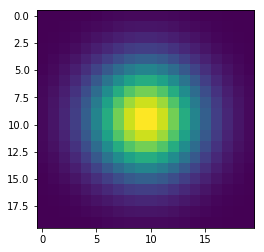

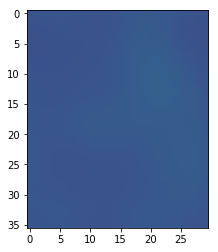

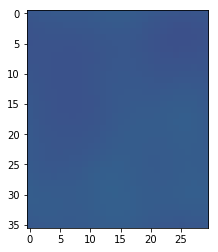

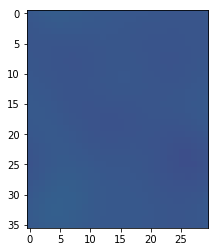

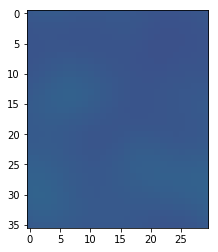

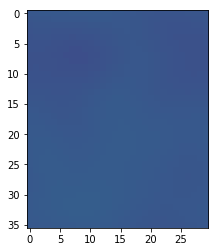

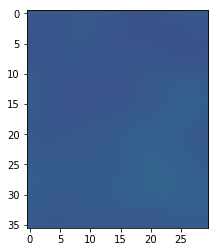

In [34]:
x = np.linspace(-3, 3, num=20)
x, y = np.meshgrid(x, x)
kernel = np.exp(-(x**2+y**2)/2.5)
kernel /= kernel.sum()
plt.imshow(kernel)
plt.show()

from scipy.signal import convolve2d

for image in images:
    conv = convolve2d(image, kernel, mode='same', boundary='wrap')
    plt.imshow(conv, vmin=350, vmax=700)
    plt.show()

In [35]:
image.max()
image.min()

343

In [36]:
def peak_volume(p):
    M = p.getShape().metric()
    return np.pi * 4 / 3.0 / np.sqrt(np.linalg.det(M))

In [37]:
nshells = 20
dmin = 1.5
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

included = 0

for peak in predicted:
    inten = peak.getCorrectedIntensity()
    I = inten.value()
    sigma = inten.sigma()
        
    if (sigma < 10.0):
        continue
        
    best_slice = peak.getIntegrationRegion().bestSlice()
        
    if best_slice < 4 or best_slice > 15:
        continue
        
    shells.addPeak(peak)
    included += 1
       
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:4d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", included)

 n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
 821    1.500    1.526    0.624    0.460    0.418    0.652    0.888
1036    1.526    1.554    0.541    0.406    0.353    0.600    0.866
1148    1.554    1.583    0.492    0.371    0.320    0.716    0.914
1243    1.583    1.616    0.457    0.345    0.295    0.751    0.926
1414    1.616    1.651    0.411    0.310    0.267    0.775    0.935
1506    1.651    1.689    0.377    0.287    0.241    0.810    0.946
1543    1.689    1.732    0.363    0.277    0.231    0.811    0.946
1629    1.732    1.778    0.371    0.283    0.237    0.807    0.945
1329    1.778    1.831    0.353    0.269    0.226    0.847    0.958
1143    1.831    1.890    0.406    0.302    0.269    0.830    0.952
1153    1.890    1.957    0.351    0.264    0.229    0.851    0.959
1217    1.957    2.036    0.271    0.205    0.175    0.889    0.970
1167    2.036    2.128    0.268    0.201    0.175    0.890    0.970
1315    2.128    2.241    0.327    0.247    0.2

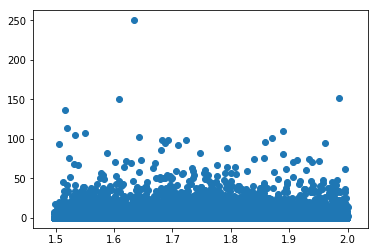

In [38]:
merged_data = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)
bad = None

for peak in predicted:
    if not peak.isSelected():
        continue
    
    inten = peak.getCorrectedIntensity()
    if inten.sigma() < 1.0:
        continue
    
    merged_data.addPeak(peak)
    
ds = []
chis = []
        
for merged_peak in merged_data.getPeaks():
    chi2 = merged_peak.chi2()
    
    d = 1.0 / np.linalg.norm(merged_peak.getPeaks()[0].getQ().rowVector())
    
    if d > 2.0:
        continue
    
    ds.append(d)
    chis.append(chi2)
    
    if chi2 > 200:
        bad = merged_peak
    
plt.scatter(ds, chis)
plt.show()

In [39]:
bad

<pynsx.MergedPeak; proxy of <Swig Object of type 'std::set< nsx::MergedPeak >::value_type *' at 0x7fed603133f0> >

In [40]:
def show_peak(p):
    bb = p.getShape().aabb()
    upper = bb.upper()
    lower = bb.lower()

    xmin = int(lower[0,0])
    xmax = int(upper[0,0])
    ymin = int(lower[1,0])
    ymax = int(upper[1,0])
    zmin = int(lower[2,0])
    zmax = int(upper[2,0])

    z = round(0.5*(zmin+zmax))

    expand=5
    
    print(lower.transpose(), upper.transpose())

    image = data.frame(z)
    image = image[ymin-expand:ymax+expand+1, xmin-expand:xmax+expand+1]
    plt.imshow(image)
    plt.show()


-7.808392698186984 103.09566211791355 1.633978614338297
[[2004.5600555   447.46719499    7.41483192]] [[2010.24027462  452.54671879    8.97659373]]


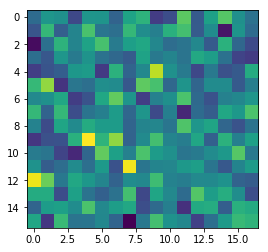

19890.83639047453 1775.386923518 1.6345599998095646
[[906.1831484  897.03644678 -35.71061842]] [[3255.52636666  899.05490744  131.53266322]]


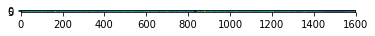

-8.44040295646903 44.56294350242385 1.6344749029441177
[[906.13578537 897.13539944 -35.67094223]] [[3255.821517    899.15513615  131.513548  ]]


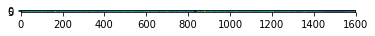

In [41]:
bad_peaks = [ p for p in bad.getPeaks() ]

for p in bad_peaks:
    inten = p.getCorrectedIntensity()    
    d = 1.0 / np.linalg.norm(p.getQ().rowVector())
    print(inten.value(), inten.sigma(), d)
    show_peak(p)

In [55]:
def distortion(p):
    A = np.linalg.inv(p.getShape().metric())
    return  np.power(np.linalg.det(A), 2/3.0) / ((A**2).trace() / 3)

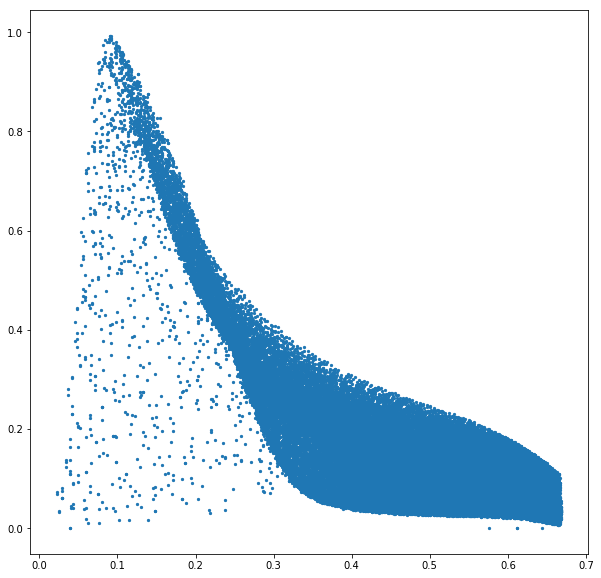

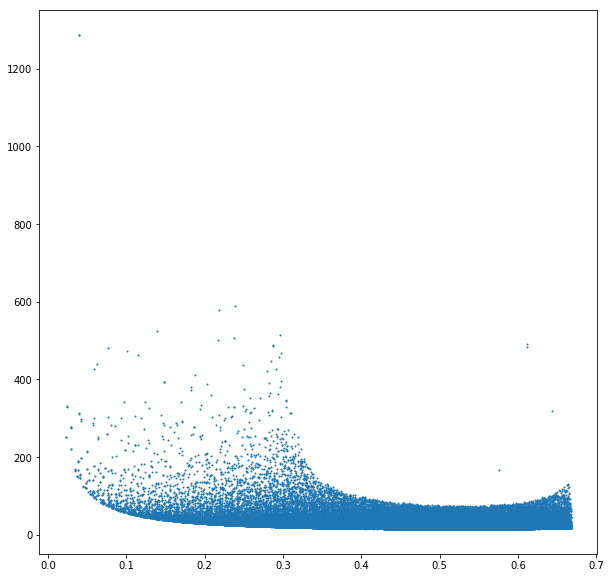

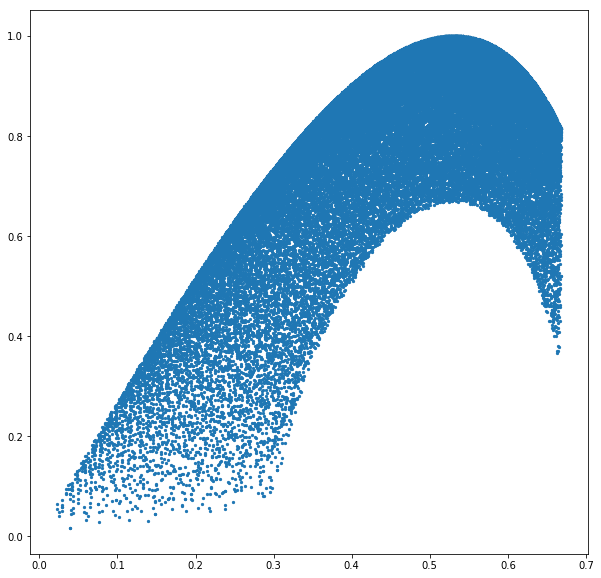

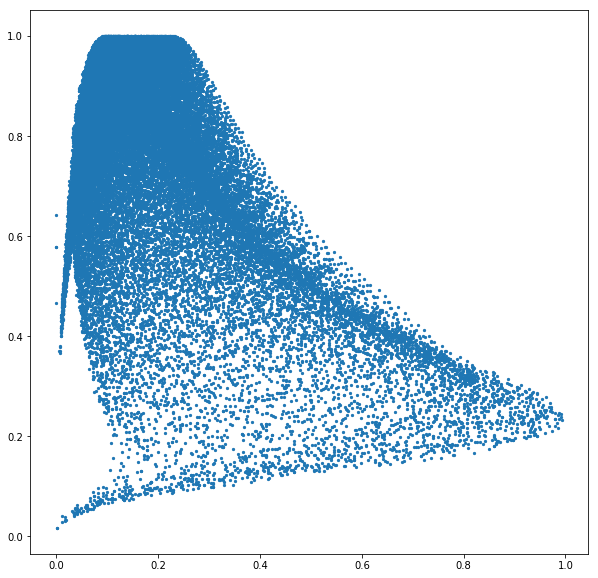

In [68]:
qs = []
ds = []
vs = []
rs = []
dists = []
lors = []

for p in predicted:
    if (p.getRawIntensity().sigma() < 1.0):
        continue
    
    v = peak_volume(p)
    vs.append(v)
    rs.append(np.power(v, 1/3.))
    q = np.linalg.norm(p.getQ().rowVector())
    qs.append(q)
    ds.append(1/q)
    dists.append(distortion(p))
    
    raw_inten = p.getRawIntensity().value()
    cor_inten = p.getCorrectedIntensity().value()
    lors.append(cor_inten/(raw_inten+1e-10))
    
plt.figure(figsize=(10,10))
plt.scatter(qs, dists, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, vs, s=1.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(qs, lors, s=5.0)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(dists, lors, s=5.0)
plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(ds, rs, s=1.0)
#plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(qs, rs, s=1.0)
#plt.show()


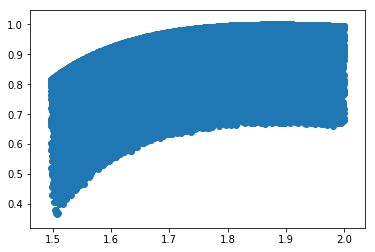

In [67]:
small_ds = []
small_lor = []

for i in range(len(ds)):
    if ds[i] > 2.0:
        continue
        
    small_ds.append(ds[i])
    small_lor.append(lors[i])
    
plt.scatter(small_ds, small_lor)
plt.show()

In [71]:
print(np.min(lors))
print(np.max(lors))

0.016572009257591967
0.9999990684522809
